In [58]:
# Import Dependencies
import os
import cv2
import time
import numpy as np
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Stack
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Evaluation Stack
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import stats

# Visualization Stack
from matplotlib import pyplot as plt

### Landmarks Definition

In [2]:
# Call mp model
holistics = mp.solutions.holistic
drawing = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
def mp_detect_hands(img, hands_model):
    # Convert image from BGR to RGB
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands_model.process(image)

    # Draw hand landmarks on the image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            drawing.draw_landmarks(
                img,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                drawing_styles.get_default_hand_landmarks_style(),
                drawing_styles.get_default_hand_connections_style()
            )
            
            # Print all the coordinates of hand landmarks
            image_height, image_width, _ = img.shape
            for ids, landmrk in enumerate(hand_landmarks.landmark):
                cx, cy = landmrk.x * image_width, landmrk.y * image_height
                print('Hand Landmark {} Coordinates: ({}, {})'.format(ids, cx, cy))
    
    
    return img

In [4]:
def mp_detect(img, holistic_model, hands_model):
    
    """Converts the image from BGR to RGB and vice versa"""
    # Convert image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb.flags.writeable = False

    # Predictions of image feed
    output_holistic = holistic_model.process(img_rgb)

    # Draw landmarks and connections on the image for face and pose
    # Draw face connections
    drawing.draw_landmarks(
        img, output_holistic.face_landmarks, 
        holistics.FACEMESH_TESSELATION,
        drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
        drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
    )

    # Draw pose connections
    drawing.draw_landmarks(
        img, output_holistic.pose_landmarks, 
        holistics.POSE_CONNECTIONS,
        drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
        drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
    )

    # Convert image back from RGB to BGR
    img_rgb.flags.writeable = True

    # Detect hands
    img_result = mp_detect_hands(img, hands_model)

    return img_result, output_holistic

In [5]:
cap = cv2.VideoCapture(0)

# Set mp model for predicting feed
with holistics.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic, \
    mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    
    while cap.isOpened():

        # Get a frame from capture device
        ret, frame = cap.read()

        # Detect hands and other holistic features
        frame_result, output = mp_detect(frame, holistic, hands)
        print(output)

        # Show image to user
        cv2.imshow("ImageFeed", frame_result)

        # Break the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release the camera
cap.release()
cv2.destroyAllWindows()

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Hand Landmark 0 Coordinates: (316.86790466308594, 349.7922992706299)
Hand Landmark 1 Coordinates: (331.75487518310547, 309.39971923828125)
Hand Landmark 2 Coordinates: (343.9255905151367, 273.8181495666504)
Hand Landmark 3 Coordinates: (346.97410583496094, 241.8610668182373)
Hand Landmark 4 Coordinates: (338.0004119873047, 212.67874717712402)
Hand Landmark 5 Coordinates: (403.33568572998047, 324.649658203125)
Hand Landmark 6 Coordinates: (430.5174255371094, 321.8067455291748)
Hand Landmark 7 Coordinates: (436.47613525390625, 322.69057273864746)
Hand Landmark 8 Coordinates: (439.3227767944336, 319.79467391967773)
Hand Landmark 9 Coordinates: (403.50032806396484, 357.51977920532227)
Hand Landmark 10 Coordina

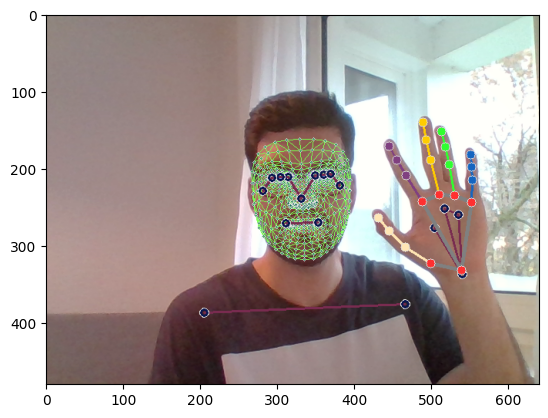

In [6]:
plt.imshow(cv2.cvtColor(frame_result, cv2.COLOR_BGR2RGB))

### Extracting Landmarks

In [7]:
print(output)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [8]:
output.pose_landmarks.landmark[0].x

0.5186758041381836

In [9]:
len(output.pose_landmarks.landmark)

33

In [10]:
output.face_landmarks.landmark[0].x

0.5218687057495117

In [11]:
len(output.face_landmarks.landmark)

468

In [12]:
def extract__all_coord(output):

    """Extracting all the available coordinates 
    and saving them in one matrix 
    """
    # Using flatten to bring all the dimensions to one dimension 
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in output.pose_landmarks.landmark]).flatten() \
    if output.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in output.face_landmarks.landmark]).flatten() \
    if output.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in output.left_hand_landmarks.landmark]).flatten() \
    if output.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in output.right_hand_landmarks.landmark]).flatten() \
    if output.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh, face, pose])

In [13]:
# lh

In [14]:
# rh

In [15]:
# pose

In [16]:
# face

### Save Data

In [17]:
frame_output = extract__all_coord(output)
frame_output

array([ 8.41378510e-01,  6.86040163e-01,  3.22991013e-07, ...,
        2.92929888e+00, -2.91900694e-01,  1.33211179e-05])

In [18]:
np.save('0', frame_output)

In [19]:
# Note: Mention ".npy" extension
np.load('0.npy')

array([ 8.41378510e-01,  6.86040163e-01,  3.22991013e-07, ...,
        2.92929888e+00, -2.91900694e-01,  1.33211179e-05])

### Landmark Data Collection

In [25]:
# Path to data
data_path = os.path.join('Action_Data') 

# Sign detection
signs = np.array(['hello', 'father', 'bye', 'mother', 'me', 'i love you'])

# Number of videos
num_seq = 30

# Number of frames per video
len_seq = 30

# Folder start
folder = 0

In [26]:
for sign in signs:
    for sequence in range(num_seq):
        try:
            os.makedirs(os.path.join(data_path, sign, str(sequence)))
        except:
            pass

### Landmark Collection for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)

# Set mp model for predicting feed
with holistics.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic, \
    mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    # Loop for new sign collection
    for s in signs:
        
        # Loop for number of videos
        for seq in range(folder, folder + num_seq):
            
            # Ensure the sign folder exists
            sign_folder = os.path.join(data_path, s)
            if not os.path.exists(sign_folder):
                os.makedirs(sign_folder)

            # Ensure the sequence folder exists
            seq_folder = os.path.join(sign_folder, str(seq))
            if not os.path.exists(seq_folder):
                os.makedirs(seq_folder)

            # Loop for frame in videos
            for len_frame in range(len_seq):

                # Get a frame from capture device
                ret, frame = cap.read()

                # Detect hands and other holistic features
                frame_result, output = mp_detect(frame, holistic, hands)
                print(output)

                # Wait Logic for collection of videos
                if len_frame == 0:
                    cv2.putText(
                        frame_result, 
                        'TAKE IMAGE', 
                        (120, 200), 
                        cv2.FONT_ITALIC, 
                        1, (119, 255, 0), 4, 
                        cv2.LINE_8
                    )
                    
                    cv2.putText(
                        frame_result, 
                        'Frame Collection For: {}, Video Number: {}'.format(s, seq), 
                        (15, 12), cv2.FONT_ITALIC, 0.5, (0, 162, 255), 2, cv2.LINE_8
                    )

                    # Wait time between sign collection
                    cv2.waitKey(3000)

                else:
                    cv2.putText(
                        frame_result, 
                        'Frame Collection For: {}, Video Number: {}'.format(s, seq), 
                        (15, 12), cv2.FONT_ITALIC, 0.5, (0, 162, 255), 2, cv2.LINE_8
                    )

                # Sign landmarks Collection Path
                lm = extract__all_coord(output)
                
                # Path to frame
                frame_path = os.path.join(data_path, s, str(seq), str(len_frame))
                np.save(frame_path, lm)
                

                # Show image to user
                cv2.imshow("ImageFeed", frame_result)

                # Break the loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

# Release the camera
cap.release()
cv2.destroyAllWindows()

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [24]:
cap.release()
cv2.destroyAllWindows()

### Feature Engineering

In [28]:
labels = {key:value for value, key in enumerate(signs)}
labels

{'hello': 0, 'father': 1, 'bye': 2, 'mother': 3, 'me': 4, 'i love you': 5}

In [29]:
# Initialize empty lists to store input data and corresponding labels
x_data, y_data = [], []

# Loop through each sign in the dataset
for sign in signs:

    # Loop through the specified number of sequences for each sign
    for seq in range(num_seq):
        frames = []

        # Initialize an empty list to store frames for the sequence
        for frame_len in range(len_seq):

            # Load the landmarks data for the each frame
            result = np.load(
                os.path.join(
                    data_path, 
                    sign, 
                    str(seq), 
                    '{}.npy'.format(frame_len)
                )
            )

            # Append the loaded data to the frames list
            frames.append(result)
            
        # Append the frames list to the input data 
        x_data.append(frames)
        # Append the label corresponding to the current sign to the labels list
        y_data.append(labels[sign])

In [30]:
print(np.array(x_data).shape)
print(np.array(y_data).shape)

(180, 30, 1662)
(180,)


In [31]:
X = np.array(x_data)
y = to_categorical(y_data).astype(int)

In [32]:
X.shape

(180, 30, 1662)

In [33]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

### Split Data into Training and Testset

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.30)

In [35]:
print(X_train.shape)
print(y_train.shape)

(126, 30, 1662)
(126, 6)


### Logging

In [36]:
log_dir = os.path.join('Logs')
callbacks_log = TensorBoard(log_dir=log_dir) 

### LSTM Model

In [37]:
# Neural Network Model Creation
model = Sequential()

# Number of Layers
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(signs.shape[0], activation='softmax'))

# Show Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           916992    
                                                                 
 batch_normalization (Batch  (None, 30, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           394240    
                                                                 
 batch_normalization_1 (Bat  (None, 30, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0

In [38]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['categorical_accuracy']
)

In [39]:
# Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stopping = EarlyStopping(
    monitor='categorical_accuracy', 
    patience=3
)

In [40]:
history = model.fit(
    X_train, y_train, epochs=500, verbose=2, 
    callbacks=[callbacks_log]
)

Epoch 1/500
4/4 - 6s - loss: 2.7452 - categorical_accuracy: 0.1349 - 6s/epoch - 2s/step
Epoch 2/500
4/4 - 1s - loss: 2.7066 - categorical_accuracy: 0.1587 - 882ms/epoch - 221ms/step
Epoch 3/500
4/4 - 1s - loss: 2.3635 - categorical_accuracy: 0.2381 - 776ms/epoch - 194ms/step
Epoch 4/500
4/4 - 1s - loss: 2.6233 - categorical_accuracy: 0.1111 - 723ms/epoch - 181ms/step
Epoch 5/500
4/4 - 1s - loss: 2.3725 - categorical_accuracy: 0.1270 - 763ms/epoch - 191ms/step
Epoch 6/500
4/4 - 1s - loss: 2.0592 - categorical_accuracy: 0.2778 - 799ms/epoch - 200ms/step
Epoch 7/500
4/4 - 1s - loss: 2.0038 - categorical_accuracy: 0.2460 - 767ms/epoch - 192ms/step
Epoch 8/500
4/4 - 1s - loss: 2.0532 - categorical_accuracy: 0.2381 - 722ms/epoch - 180ms/step
Epoch 9/500
4/4 - 1s - loss: 2.0306 - categorical_accuracy: 0.2540 - 660ms/epoch - 165ms/step
Epoch 10/500
4/4 - 1s - loss: 2.1274 - categorical_accuracy: 0.2143 - 670ms/epoch - 168ms/step
Epoch 11/500
4/4 - 1s - loss: 2.2384 - categorical_accuracy: 0.19

### Predictions

In [41]:
pred = model.predict(X_test)

2/2 [==============================] - 1s 31ms/step


In [50]:
signs[np.argmax(pred[8])]

'bye'

In [51]:
signs[np.argmax(y_test[8])]

'bye'

### Save Model

In [52]:
model.save('sign_detection.h5')

### Evaluation

In [56]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(pred, axis=1).tolist()

In [140]:
confusion_matrix(y_true, y_pred)

array([[16,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  1],
       [ 0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  1,  8,  0,  0,  0],
       [ 0,  1,  0,  1,  3,  0,  8],
       [ 0,  0,  0,  0,  1,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  2]])

In [57]:
accuracy_score(y_true, y_pred)

0.8518518518518519